## tl;dr

* Shifting the polygon away from origin introduces error in area computation in the georust implementation.
  * Some of this error is unavoidable with any implementation due to use of floating point arithmetic.
  * For georust, in this example, the error is ~1 when shifted 1e17 away from origin in a direction not aligned to the x/y axis. At that point, the area computation results in the value of 0.
* For a naive implementation, the error is huge (relative error up to 1e14 when shifted 1e17 away from origin).
  * Error remains small when shifted along x or y axis.

# Prerequisites

Generate data:

```sh
cd harness
cargo run --bin area_numerical_stability > ../analysis/area_numerical_stability/data.json
```

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('dark_background')


In [3]:
def _flatten(series):
    flattened = []
    for entry in series:
        angle = entry['angle']
        for datum in entry['data']:
            datum['angle'] = angle
            flattened.append(datum)
    return flattened


with open('./data.json') as f:
    data = _flatten(json.loads(f.read()))
df = pd.json_normalize(data)

print(df.describe())


              shift  geo_shift_relative_error       angle  geo.original  \
count  3.200000e+02              3.200000e+02  320.000000    320.000000   
mean   4.323456e+17              1.230662e-01    0.785398    293.892626   
std    1.952607e+18              3.172078e-01    0.556230      0.000000   
min    1.500000e+00              0.000000e+00    0.000000    293.892626   
25%    8.601600e+04              1.456419e-13    0.392699    293.892626   
50%    4.831838e+09              4.066990e-09    0.785398    293.892626   
75%    2.638828e+14              6.981555e-04    1.178097    293.892626   
max    1.383506e+19              1.000000e+00    1.570796    293.892626   

       geo.shifted  geos.original  geos.shifted  naive.original  \
count   320.000000     320.000000    320.000000      320.000000   
mean    262.912068     293.892626    262.912068      293.892626   
std      95.080734       0.000000     95.080734        0.000000   
min       0.000000     293.892626      0.000000      293

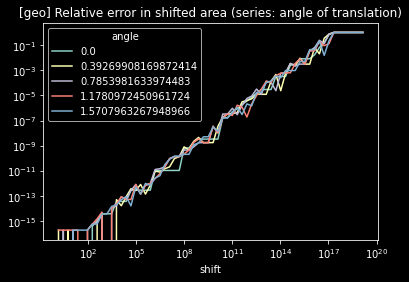

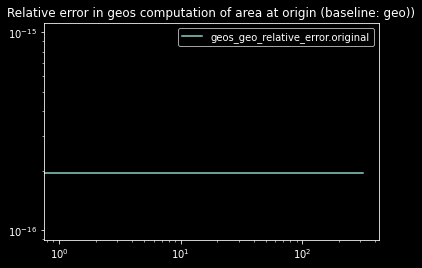

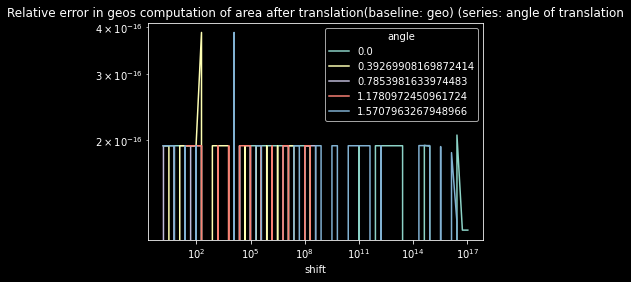

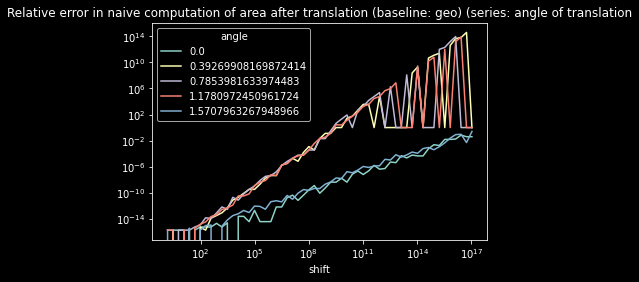

In [4]:
series = df.pivot(
    index='shift', 
    columns='angle', 
    values=[
        'geo_shift_relative_error', 
        'geos_geo_relative_error.original', 
        'geos_geo_relative_error.shifted',
        'naive_geo_relative_error.shifted',
    ])
series.plot(y='geo_shift_relative_error', kind='line', logx=True, logy=True,
            title='[geo] Relative error in shifted area (series: angle of translation)')

df.plot(y='geos_geo_relative_error.original', kind='line', logx=True, logy=True,
            title='Relative error in geos computation of area at origin (baseline: geo))')
series.plot(y='geos_geo_relative_error.shifted', kind='line', logx=True, logy=True,
            title='Relative error in geos computation of area after translation(baseline: geo) (series: angle of translation')

ax = series.plot(y='naive_geo_relative_error.shifted', kind='line', logx=True, logy=True,
            title='Relative error in naive computation of area after translation (baseline: geo) (series: angle of translation')

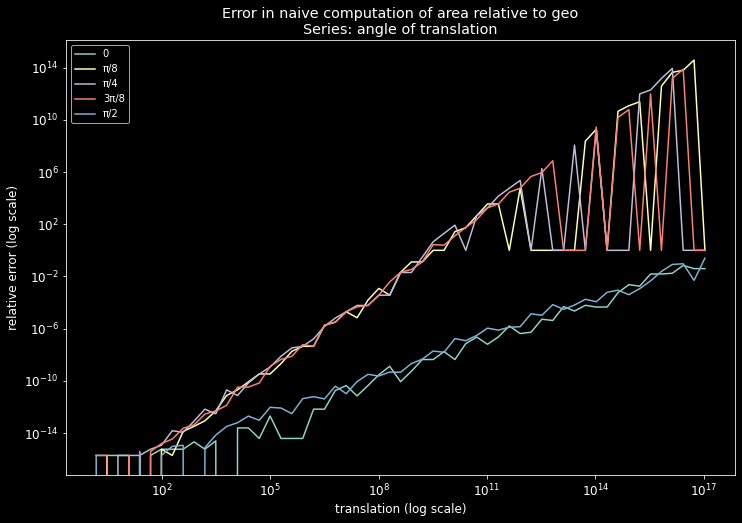

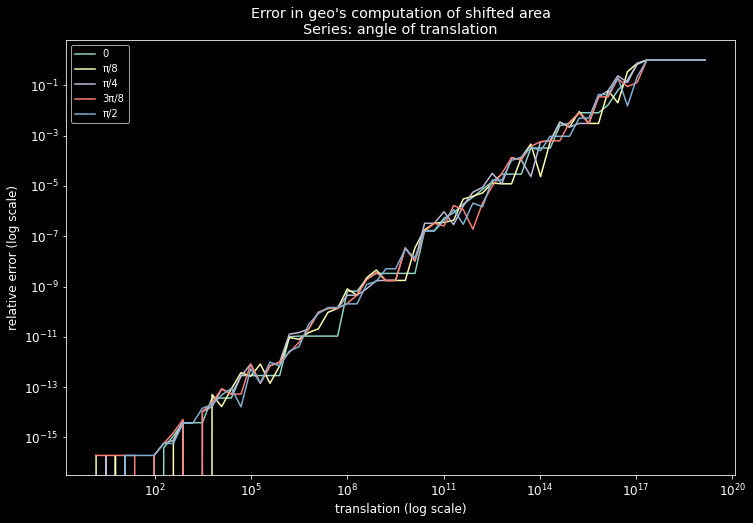

In [9]:
# The most important plots, with better legend etc.

@plt.rc_context({
    'figure.figsize': (12, 8),
    'font.size': 12,
    'image.cmap': plt.get_cmap('Pastel1'),
})
def plot_with_styling(f):
    return f()

ax = plot_with_styling(lambda: series.plot(
    title='Error in naive computation of area relative to geo\nSeries: angle of translation',
    y='naive_geo_relative_error.shifted', 
    kind='line', 
    logx=True, 
    logy=True, 
))
ax.legend(['0', 'π/8', 'π/4', '3π/8', 'π/2'])
ax.set_xlabel('translation (log scale)')
ax.set_ylabel('relative error (log scale)')
plt.savefig('naive_area_error.svg', transparent=True)

ax = plot_with_styling(lambda: series.plot(
    title='Error in geo\'s computation of shifted area\nSeries: angle of translation',
    y='geo_shift_relative_error',
    kind='line',
    logx=True,
    logy=True,
))
ax.legend(['0', 'π/8', 'π/4', '3π/8', 'π/2'])
ax.set_xlabel('translation (log scale)')
ax.set_ylabel('relative error (log scale)')
plt.savefig('geo_area_error.svg', transparent=True)

# Observations

* `geos` and `geo` behave very similarly for translations in all directions
* `geos` and `geo` computation of area is stable till $~10^{17}$. Beyond that, the area is computed as 0 in this example. This is due to unavoidable loss in precision due to translation of the points.
* The naive implementation that does not translate the points closer to the origin leads to large errors. Relative error is $1$ at $~10^{9}$, and up to $~10^{14}$ at $10^{17}$.
* The actual ara in this computation is $293$. If the unit of measurement were meter, and the smallest relevant area were $1$, earth's radius would be $~10^8$.
  * The maximum relative error on earth's surface for `geos` or `geo` computation would be $~10^{-10}$.
  * The maximum relative error on earth's surface with naive computation would be $~10^{-2}$.